# Stroke GA Algorithm

Given a desired label, we search for the combination of touches that maximises the probability assigned to that label.
Such combination is the "ideal" input stroke that the network is looking for in order to predict that label

In [1]:
import os
import sys
import random
import warnings
import numpy as np


from tokenizers import Tokenizer

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

from pathlib import Path
from IPython.display import SVG, display

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

### Enable Hot Reload

In [2]:
%load_ext autoreload
%autoreload 2

### Edit Python path
Add the `models` directory to Python's `path`.

In [3]:
b_paths = [os.path.abspath(os.path.join('..', '..', '..')), os.path.abspath(os.path.join('..', '..')), os.path.abspath(os.path.join('..', '..', 'scripts'))]
for b_path in b_paths:
    if b_path not in sys.path:
        sys.path.append(b_path)

BASE_DIR = Path(os.getcwd()).parent.parent.parent.resolve()
%cd $BASE_DIR

I:\My Drive\master_thesis_experiments\glyph-recognition-experiments


### Ignore Warnings

In [4]:
warnings.filterwarnings('ignore')

### Import Helpers

In [5]:
from models.scripts.transformer.PreEncoders import Conv1DTransformer
from models.scripts.transformer.Transformer import Transformer
from models.scripts.transformer.utils import strokes_to_svg, seed_all, load_json_hypeparameters, pad_collate_fn
from models.scripts.defaults import *

In [6]:
N_STROKES_TO_OPTIMIZE = 1 # for now, working only with 1
VERSION = 'en-en11'
SEED = 2021
LABEL = "C"
seed_all(SEED)

### Load vocab

In [7]:
TOKENIZER_FILE = os.path.join("word_sources","tokenizer-big_en-normalized.json")
VOCAB = Tokenizer.from_file(TOKENIZER_FILE)

BOS_IDX = VOCAB.token_to_id('<bos>')
EOS_IDX = VOCAB.token_to_id('<eos>')
PAD_IDX = VOCAB.token_to_id('<pad>')

N_TOKENS = VOCAB.get_vocab_size() # len(VOCAB)
print(f"Number of Tokens: {N_TOKENS}\n")
print(sorted(VOCAB.get_vocab()))

Number of Tokens: 2000

['!', '!!', '!!!', '"', '#', '$', '%', '&', "'", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '(', ')', '),', ').', '*', '+', ',', ',"', '-', '.', '."', '..', '...', '....', '.....', '........', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '<bos>', '<eos>', '<pad>', '<unk>', '=', '>', '?', '??', '@', 'A', 'B', 'BC', 'C', 'D', 'E', 'ER', 'F', 'G', 'H', 'I', 'IN', 'It', 'J', 'K', 'L', 'M', 'N', 'O', 'OT', 'P', 'Q', 'R', 'S', 'T', 'The', 'U', 'V', 'W', 'We', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'ab', 'able', 'ably', 'abour', 'ac', 'acc', 'ace', 'ach', 'ack', 'act', 'acy', 'ad', 'ade', 'ady', 'af', 'aff', 'ag', 'age', 'ages', 'ague', 'ah', 'ai', 'aid', 'aign', 'ail', 'aim', 'ain', 'ained', 'aining', 'ains', 'air', 'ait', 'aj', 'ajor', 'ak', 'ake', 'aken', 'akes', 'aking', 'al', 'ald', 'ale', 'ales', 'alf', 'alif', 'ality', 'all', 'ally', 'als', 'alth', 'am', 'ama', 'ame', 'ament', 'amer', 'ames', 'amp', 'an', 'anc', 'ance', 'an

### Generate label for the model

In [8]:
tensor_lab = torch.tensor(VOCAB.encode(LABEL).ids)
print(tensor_lab)
value = {i for i in VOCAB.get_vocab() if VOCAB.get_vocab()[i]==tensor_lab.item()}
print("key by value:",value)

tensor([304])
key by value: {'ĠC'}


### Load model

In [9]:
hp = load_json_hypeparameters(VERSION)
if "vocab" in hp:
    hp.pop("vocab")
model = Conv1DTransformer(name=VERSION, vocab=VOCAB, **hp)
model.load_best_version()
model.to(model.device)

Conv1DTransformer(
  (alpha_scaling): AlphaScaling(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
      

## Define the GA

### Define constants

In [10]:
POPULATION_SIZE = 500
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.15   # probability for mutating an individual
MAX_GENERATIONS = 450
HALL_OF_FAME = 15
CROWDING_FACTOR_CROSS = 22.0
CROWDING_FACTOR_MUT = 5.0

# Alternative way

In [11]:
BOUNDS_LOW =[0]*VECTOR_SIZE + [0]
BOUNDS_HIGH = [1]*VECTOR_SIZE + [VECTOR_SIZE//N_FEATURES]
print(len(BOUNDS_LOW), len(BOUNDS_HIGH))
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create('FitnessMin', base.Fitness, weights=(-1,))

# create the Individual class based on list:
creator.create('Individual', list, fitness=creator.FitnessMin)

# define the attributes individually:
for i in range(VECTOR_SIZE+1):
    toolbox.register("touch_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

# create a tuple containing an attribute generator for each param searched:
touches = ()
for i in range(VECTOR_SIZE+1):
    touches = touches + \
                      (toolbox.__getattribute__("touch_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 touches,
                 n=1)

# create the population operator to generate a list of individuals:
toolbox.register('populationCreator', tools.initRepeat, list, toolbox.individualCreator)

# fitness calculation
def compute_fitness(individual):

    strokes = individual.copy()[:VECTOR_SIZE]
    pads = int(individual.copy()[-1])*N_FEATURES
    for v in range(VECTOR_SIZE-pads, VECTOR_SIZE):
        strokes[v] = SRC_PAD_IDX
    src = torch.tensor(strokes).reshape(N_STROKES_TO_OPTIMIZE, VECTOR_SIZE)
    bos_vector = torch.zeros([1, VECTOR_SIZE]) + BOS_IDX
    eos_vector = torch.zeros([1, VECTOR_SIZE]) + EOS_IDX
    pad_vector = torch.zeros([ENCODER_INPUT_LENGTH-2-src.shape[0], VECTOR_SIZE]) + SRC_PAD_IDX

    src = torch.cat([bos_vector, src, eos_vector, pad_vector], dim=0).to(model.device)

    #assert src.shape == (200,128)
    iterator = [(src, tensor_lab)]
    evaluator = DataLoader(iterator, collate_fn=pad_collate_fn, batch_size=1)
    out = model.evaluate_f(evaluator)
    return out,

toolbox.register('evaluate', compute_fitness)

# genetic operators:
toolbox.register('select', tools.selTournament, tournsize=2)
toolbox.register('mate',
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR_CROSS)

toolbox.register('mutate',
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR_MUT,
                 indpb=1.0 / (VECTOR_SIZE+1))

129 129


In [12]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

gen	nevals	min    	avg    
0  	500   	3.69687	5.87919
1  	440   	2.58756	5.70769
2  	452   	1.64902	5.54669
3  	450   	1.64902	5.32152
4  	423   	1.64902	5.10722
5  	441   	1.49727	4.85675
6  	441   	1.49727	4.64927
7  	441   	1.28035	4.46771
8  	455   	1.28035	4.23933
9  	438   	1.28035	4.11086
10 	439   	1.20531	3.98284
11 	438   	1.20531	3.9203 
12 	444   	1.19303	3.72315
13 	438   	0.741  	3.58441
14 	436   	0.741  	3.50328
15 	444   	0.741  	3.33497
16 	453   	0.674855	3.08202
17 	445   	0.522852	2.97263
18 	455   	0.522852	2.77934
19 	454   	0.479062	2.51794
20 	447   	0.479062	2.3545 
21 	452   	0.479062	2.23814
22 	433   	0.479062	2.09337
23 	440   	0.472105	1.9564 
24 	432   	0.472105	1.89559
25 	438   	0.472105	1.69294
26 	441   	0.472105	1.63886
27 	448   	0.461255	1.54818
28 	441   	0.461255	1.31139
29 	426   	0.461255	1.21478
30 	434   	0.391257	1.06698
31 	454   	0.391257	0.947071
32 	444   	0.391257	0.871206
33 	452   	0.372819	0.833061
34 	430   	0.357392	0.725838
35 	4

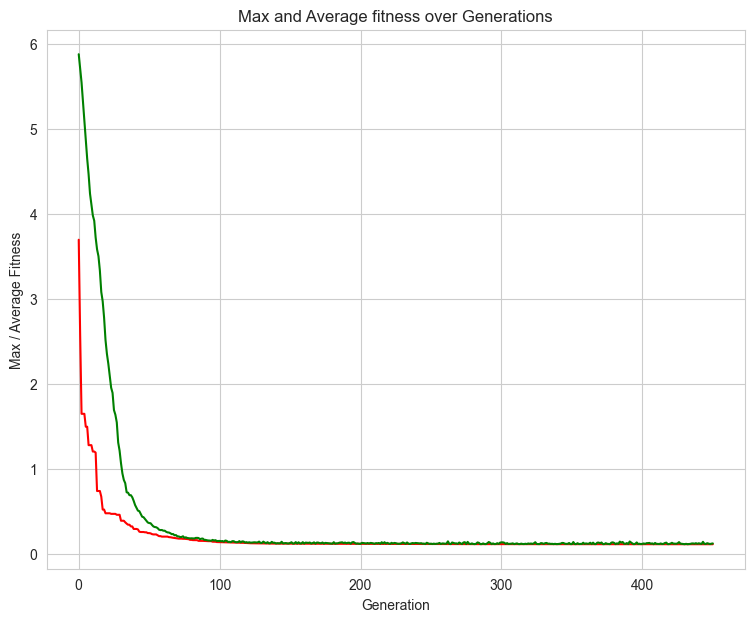

In [13]:
# create initial population (generation 0):
population  = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# extract statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

# plot statistics:
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

In [14]:
# print best solution found:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

-- Best Ever Individual =  [0.7308217880783335, 0.30007935635076444, 0.4972050851184249, 0.08691315571011188, 0.3576937592866472, 0.6050122399846011, 0.44452418473489025, 0.27147852843204734, 0.13765354841267036, 0.18012789036261365, 0.6841536050221158, 0.9849830675624939, 0.3727875043379761, 0.5070504299898485, 0.19295920293548938, 0.28083297208039093, 1.9428210872876246e-05, 0.013557486293306593, 0.709491800464979, 0.6561964400811948, 0.14350581347671612, 0.9999991281030615, 0.01923551637290028, 0.09054176301762937, 0.8935990504059245, 0.4190899074536342, 0.495278000674059, 0.9920506822375151, 0.48787364561829955, 0.8829043393792931, 0.9999951967384417, 0.47493812012104, 0.989139913732321, 0.23967799807604562, 0.09929347420543501, 0.3559729770767189, 0.4907005162402374, 0.6314450223905258, 0.9878394515759511, 0.060604669523525875, 0.7634962102640632, 0.3916094026180305, 0.40947387258483525, 0.1669865773171007, 0.09586038391271615, 0.12484587556861171, 0.7461133798719042, 0.4690538435

In [ ]:
strokes = best.copy()[:VECTOR_SIZE]
pads = int(best.copy()[-1])*N_FEATURES
for v in range(VECTOR_SIZE-pads, VECTOR_SIZE):
    strokes[v] = SRC_PAD_IDX
src = torch.tensor(strokes).reshape(N_STROKES_TO_OPTIMIZE, VECTOR_SIZE)
bos_vector = torch.zeros([1, VECTOR_SIZE]) + BOS_IDX
eos_vector = torch.zeros([1, VECTOR_SIZE]) + EOS_IDX
pad_vector = torch.zeros([ENCODER_INPUT_LENGTH-2-src.shape[0], VECTOR_SIZE]) + SRC_PAD_IDX

src = torch.cat([bos_vector, src, eos_vector, pad_vector], dim=0)

svg_str = strokes_to_svg(src, {'height':100, 'width':100}, SRC_PAD_IDX, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

print(src.shape)
print(src)
print(src[1]) # generated stroke